In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree


In [38]:
class CART(object):
    def __init__(self, tree='cls', criterion='gini', prune='depth', max_depth=4, min_criterion=0.05):
        self.feature = None
        self.label = None
        self.n_samples = None
        self.gain = None
        self.left = None
        self.right = None
        self.threshold = None
        self.depth = 0

        self.root = None
        self.criterion = criterion
        self.prune = prune
        self.max_depth = max_depth
        self.min_criterion = min_criterion
        self.tree = tree

    #train
    def fit(self, features, target):
        self.root = CART()
        if self.tree == 'cls':
            self.root._grow_tree(features, target, self.criterion)
        else:
            self.root._grow_tree(features, target, 'mse')
        self.root._prune(self.prune, self.max_depth, self.min_criterion, self.root.n_samples)

    #dự đoán
    def predict(self, features):
        return np.array([self.root._predict(f) for f in features])

    def print_tree(self):
        self.root._show_tree(0, ' ')

    def _grow_tree(self, features, target, criterion='gini'):
        self.n_samples = features.shape[0]

        if len(np.unique(target)) == 1:
            self.label = target[0]
            return

        best_gain = 0.0
        best_feature = None
        best_threshold = None

        if criterion in {'gini', 'entropy'}:
            self.label = max([(c, len(target[target == c])) for c in np.unique(target)], key=lambda x: x[1])[0]
        else:
            self.label = np.mean(target)

        impurity_node = self._calc_impurity(criterion, target)

        for col in range(features.shape[1]):
            feature_level = np.unique(features[:, col])
            thresholds = (feature_level[:-1] + feature_level[1:]) / 2.0

            for threshold in thresholds:
                target_l = target[features[:, col] <= threshold]
                impurity_l = self._calc_impurity(criterion, target_l)
                n_l = float(target_l.shape[0]) / self.n_samples

                target_r = target[features[:, col] > threshold]
                impurity_r = self._calc_impurity(criterion, target_r)
                n_r = float(target_r.shape[0]) / self.n_samples

                impurity_gain = impurity_node - (n_l * impurity_l + n_r * impurity_r)
                if impurity_gain > best_gain:
                    best_gain = impurity_gain
                    best_feature = col
                    best_threshold = threshold

        self.feature = best_feature
        self.gain = best_gain
        self.threshold = best_threshold
        self._split_tree(features, target, criterion)

    def _split_tree(self, features, target, criterion):
        features_l = features[features[:, self.feature] <= self.threshold]
        target_l = target[features[:, self.feature] <= self.threshold]
        self.left = CART()
        self.left.depth = self.depth + 1
        self.left._grow_tree(features_l, target_l, criterion)

        features_r = features[features[:, self.feature] > self.threshold]
        target_r = target[features[:, self.feature] > self.threshold]
        self.right = CART()
        self.right.depth = self.depth + 1
        self.right._grow_tree(features_r, target_r, criterion)

    def _calc_impurity(self, criterion, target):
        if criterion == 'gini':
            return 1.0 - sum([(float(len(target[target == c])) / float(target.shape[0])) ** 2.0 for c in np.unique(target)])
        elif criterion == 'mse':
            return np.mean((target - np.mean(target)) ** 2.0)
        else:
            entropy = 0.0
            for c in np.unique(target):
                p = float(len(target[target == c])) / target.shape[0]
                if p > 0.0:
                    entropy -= p * np.log2(p)
            return entropy

    def _prune(self, method, max_depth, min_criterion, n_samples):
        if self.feature is None:
            return

        self.left._prune(method, max_depth, min_criterion, n_samples)
        self.right._prune(method, max_depth, min_criterion, n_samples)

        pruning = False

        if method == 'impurity' and self.left.feature is None and self.right.feature is None:
            if (self.gain * float(self.n_samples) / n_samples) < min_criterion:
                pruning = True
        elif method == 'depth' and self.depth >= max_depth:
            pruning = True

        if pruning is True:
            self.left = None
            self.right = None
            self.feature = None

    def _predict(self, d):
        if self.feature is not None:
            if d[self.feature] <= self.threshold:
                return self.left._predict(d)
            else:
                return self.right._predict(d)
        else:
            return self.label

    def _show_tree(self, depth, cond):
        base = '    ' * depth + cond
        if self.feature is not None:
            print(base + 'if X[' + str(self.feature) + '] <= ' + str(self.threshold))
            self.left._show_tree(depth + 1, 'then ')
            self.right._show_tree(depth + 1, 'else ')
        else:
            print(base + '{value: ' + str(self.label) + ', samples: ' + str(self.n_samples) + '}')
    def plot_tree(self, feature_names=None):
        def plot_node(node, x, y, dx, ax):
            if node.feature is not None:
                feature_name = f"X[{node.feature}]" if feature_names is None else feature_names[node.feature]
                ax.text(x, y, f"{feature_name} <= {node.threshold:.2f}\n"
                            f"samples = {node.n_samples}\n"
                            f"value = {node.label}", 
                        bbox=dict(facecolor='white', edgecolor='black'),
                        ha='center', va='center', fontsize=10)

                # Left child
                ax.plot([x, x - dx], [y, y - 0.2], color='gray', linewidth=2)
                plot_node(node.left, x - dx, y - 0.2, dx / 1.5, ax)

                # Right child
                ax.plot([x, x + dx], [y, y - 0.2], color='gray', linewidth=2)
                plot_node(node.right, x + dx, y - 0.2, dx / 1.5, ax)
            else:
                ax.text(x, y, f"samples = {node.n_samples}\n"
                            f"value = {node.label}",
                        bbox=dict(facecolor='lightblue', edgecolor='black'),
                        ha='center', va='center', fontsize=10)

        fig, ax = plt.subplots(figsize=(20, 10))
        ax.axis('off')

        # Set starting positions
        plot_node(self.root, 0, 0, 0.5, ax)
        
        plt.title("CART Decision Tree Visualization", fontsize=16)
        plt.tight_layout()
        plt.show()

In [39]:
def preprocess_data(data, target_column):
    # Tách features và target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Mã hóa các cột categorical
    le = LabelEncoder()
    for column in X.select_dtypes(include=['object']):
        X[column] = le.fit_transform(X[column])
    
    y = le.fit_transform(y)

    return X, y

In [40]:
def classification_example(csv_file, target_column, max_depth=3):
    print('\n\nClassification Tree')
    
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(csv_file)
    
    # Tiền xử lý dữ liệu
    X, y = preprocess_data(data, target_column)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    cls = CART(tree='cls', criterion='entropy', prune='depth', max_depth=max_depth)
    cls.fit(X_train.values, y_train)
    cls.print_tree()

    pred = cls.predict(X_test.values)
    print("This Classification Tree Prediction Accuracy:    {}".format(sum(pred == y_test) / len(pred)))

    # Vẽ cây quyết định
    cls.plot_tree(feature_names=X.columns)

In [41]:
def regression_example(csv_file, target_column, max_depth=2):
    print('\n\nRegression Tree')
    
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(csv_file)
    
    # Tiền xử lý dữ liệu
    X, y = preprocess_data(data, target_column)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    reg = CART(tree='reg', criterion='mse', prune='depth', max_depth=max_depth)
    reg.fit(X_train.values, y_train)
    reg.print_tree()

    pred = reg.predict(X_test.values)
    mse = np.mean((pred - y_test)**2)
    print('This Regression Tree Mean Squared Error: {}'.format(mse))

    # Vẽ cây quyết định
    reg.plot_tree(feature_names=X.columns)



Classification Tree
 if X[0] <= 0.320165
    then if X[1] <= 5.86535
        then if X[2] <= 3.0642
            then {value: 1, samples: 232}
            else {value: 1, samples: 169}
        else if X[0] <= -3.4448999999999996
            then {value: 1, samples: 29}
            else {value: 0, samples: 69}
    else if X[0] <= 2.2354000000000003
        then if X[2] <= -2.8728499999999997
            then {value: 1, samples: 37}
            else {value: 0, samples: 179}
        else {value: 0, samples: 314}
This Classification Tree Prediction Accuracy:    0.9504373177842566


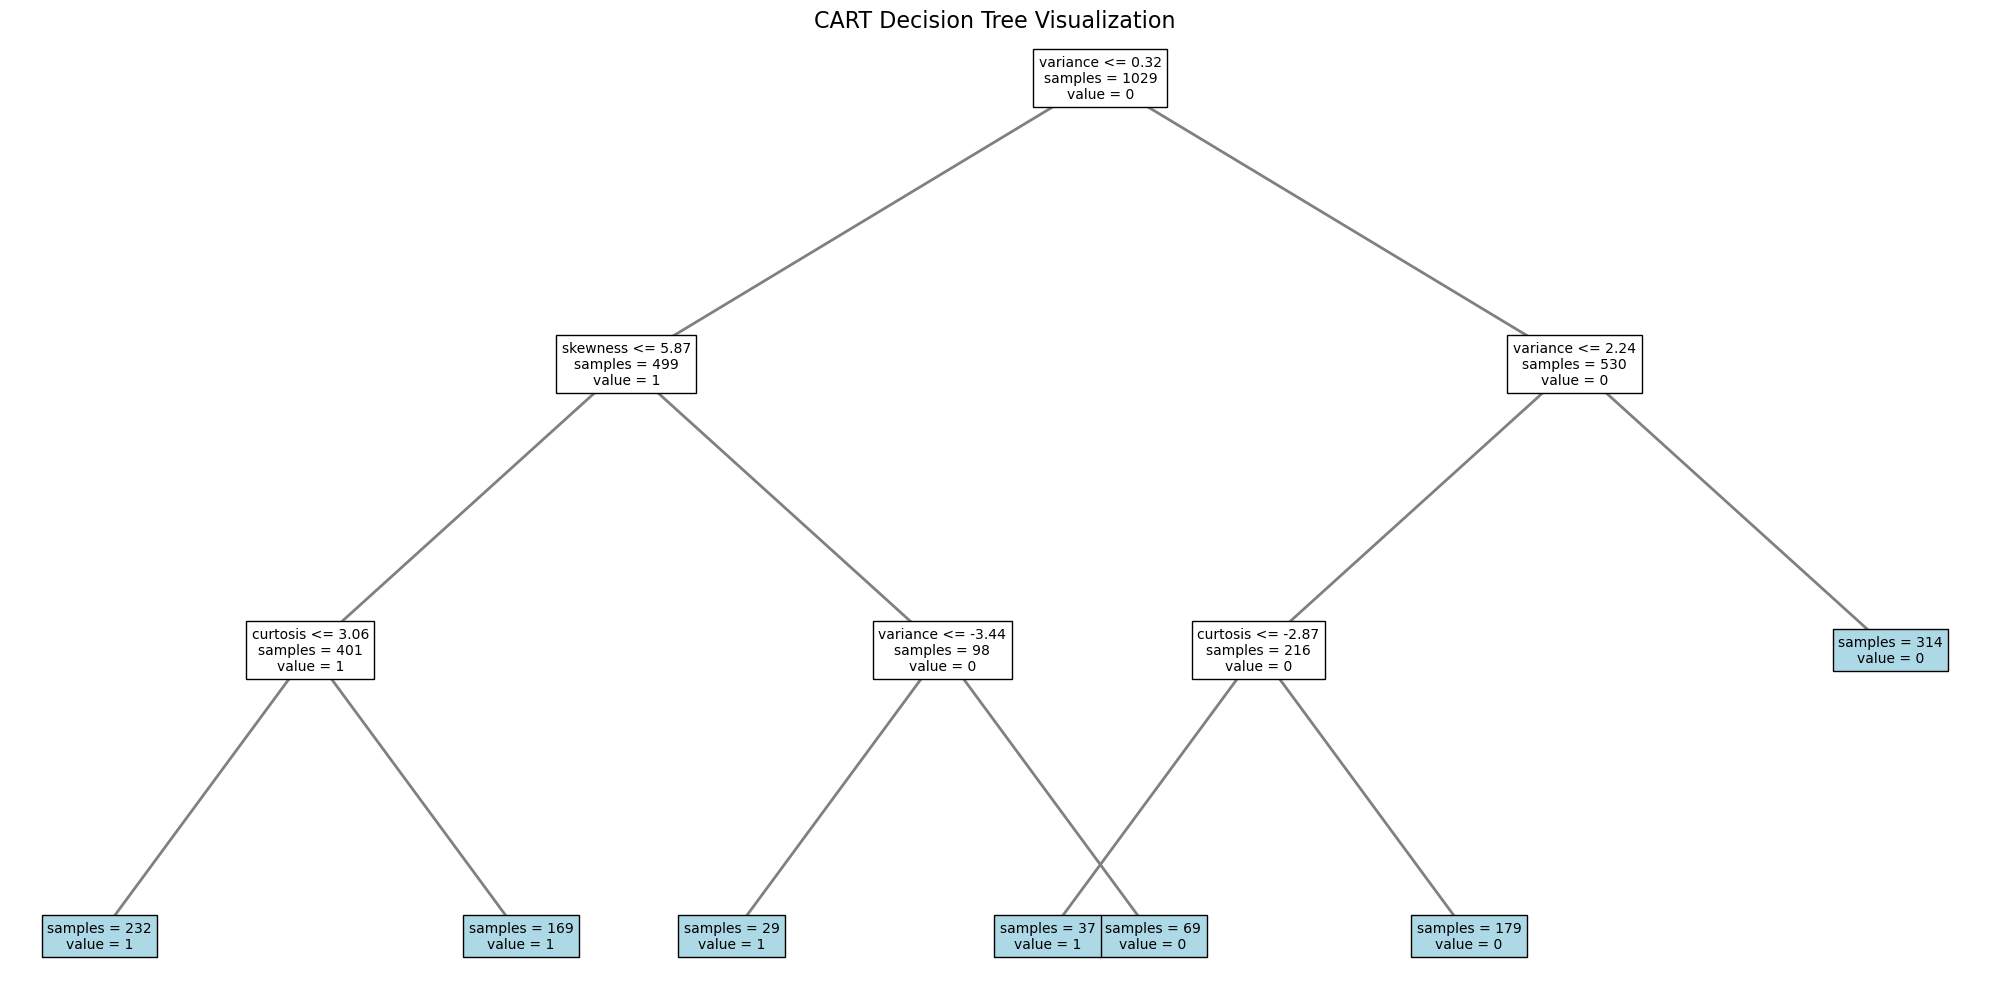



Regression Tree
 if X[1] <= 3.16495
    then if X[0] <= 2.3282499999999997
        then {value: 708.5354691075515, samples: 437}
        else {value: 938.3856209150326, samples: 153}
    else if X[1] <= 9.0955
        then {value: 441.4271844660194, samples: 309}
        else {value: 144.07692307692307, samples: 130}
This Regression Tree Mean Squared Error: 56200.753659150476


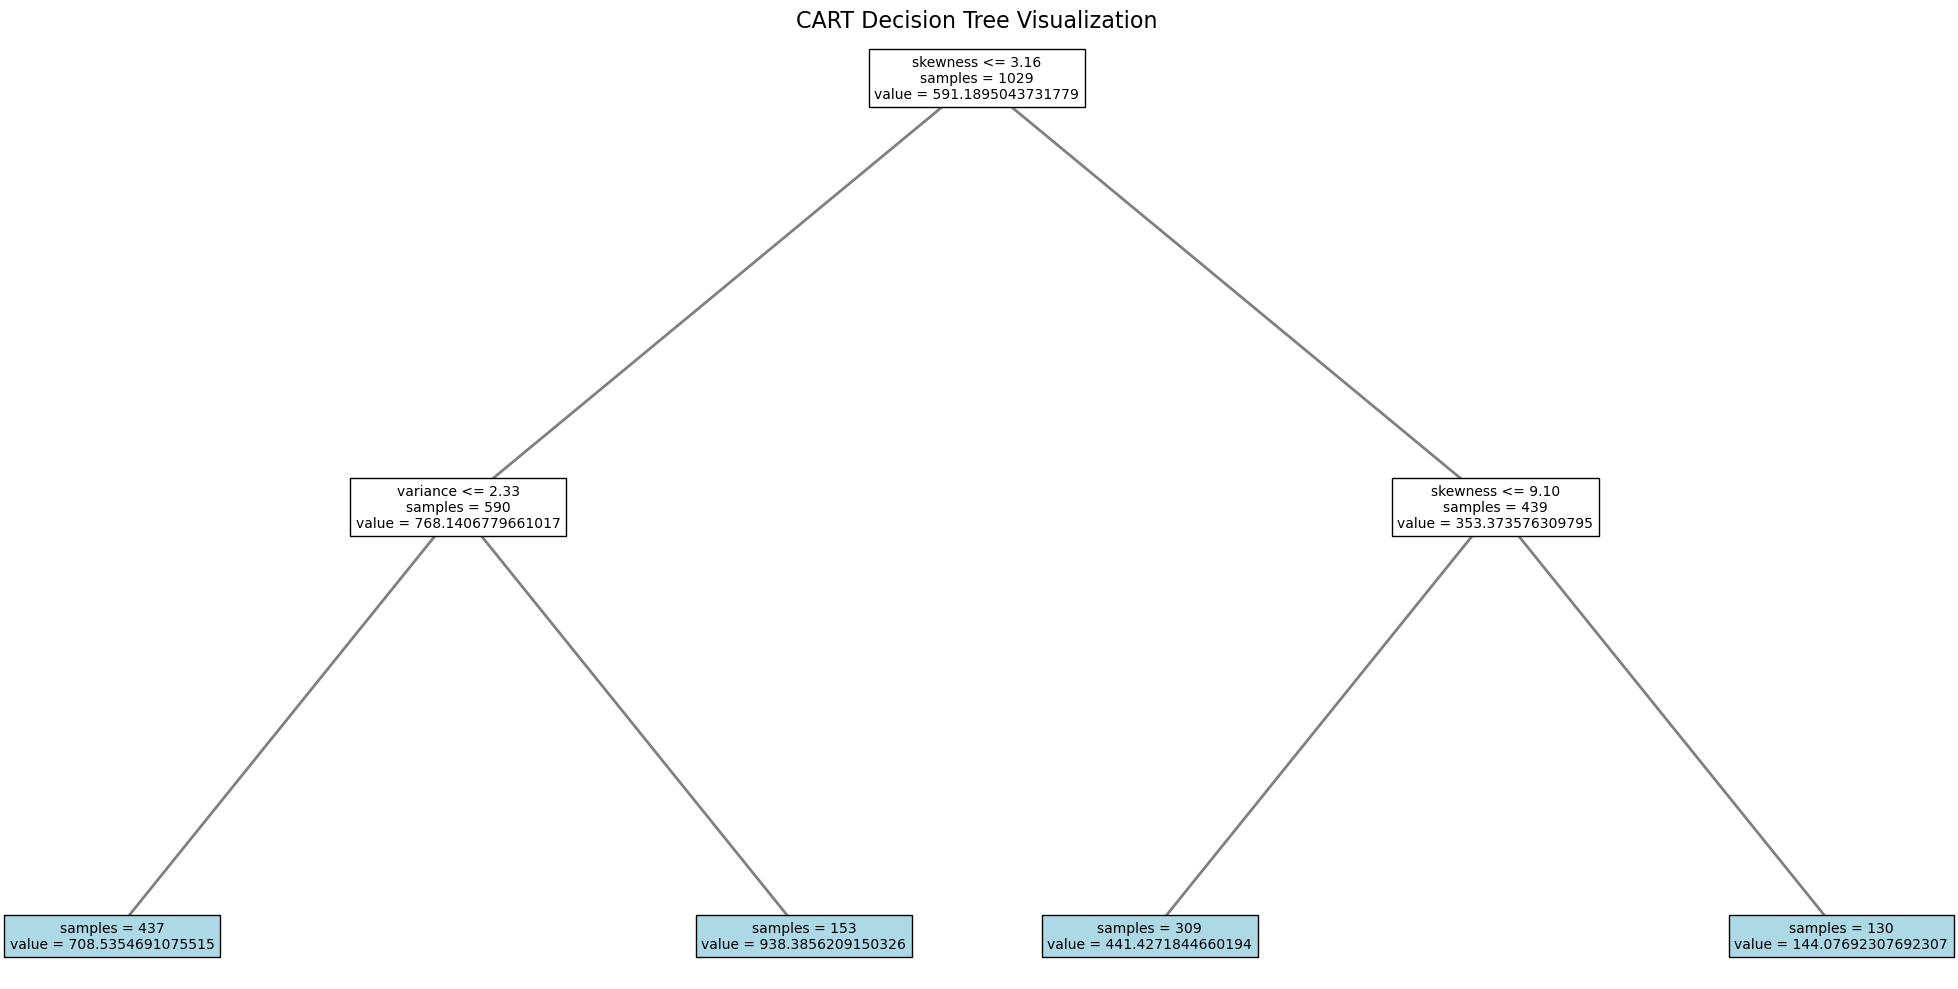

In [42]:

# Gọi hàm với đường dẫn file CSV
classification_example('dbanknote_dataset.csv', 'class')
regression_example('banknote_dataset.csv', 'entropy')